In [1]:
!pip -q install transformers beautifulsoup4 requests html5lib pandas tqdm sentence-transformers geopandas nltk unidecode matplotlib seaborn wordcloud folium
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Scraping

The scraper downloads mp3 of the national anthems as well. One can try incorporating Audio transformer also. Take embeddings of text and audio, then use late fusion. It might give different results. For now, I am leaving it for future purposes. This implementation deals with text only.

In [2]:
import os
base_path = 'gdrive/MyDrive/transformer-based-national-anthems-clustering/'
if os.path.isdir(base_path) == False:
    !mkdir gdrive/MyDrive/transformer-based-national-anthems-clustering/
    !mkdir gdrive/MyDrive/transformer-based-national-anthems-clustering/data/
    !mkdir gdrive/MyDrive/transformer-based-national-anthems-clustering/data/audio/
    !wget https://raw.githubusercontent.com/lucas-de-sa/national-anthems-clustering/master/datasets/anthems.csv -P gdrive/MyDrive/transformer-based-national-anthems-clustering/data/
    !wget https://raw.githubusercontent.com/lucas-de-sa/national-anthems-clustering/master/datasets/world-countries.json -P -P gdrive/MyDrive/transformer-based-national-anthems-clustering/data/

In [3]:
import requests
from bs4 import BeautifulSoup
import os.path
import pandas as pd
from IPython.display import display, HTML
from tqdm import tqdm
import subprocess, time

headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.135 Safari/537.36 Edge/12.246"}

try:
    df = pd.read_csv(base_path+'data/anthems_scraped.csv')
except:
    df = pd.read_csv(base_path+'data/anthems.csv')
    df['nationalanthems.info'] = 'None'
    df['Native_script'] = 'None'
    df['Transliterated'] = 'None'
    df['Translated'] = 'None'

for i, row in tqdm(df.iterrows(), total=len(df)):
    if df.loc[i,'nationalanthems.info'] != 'None':
        continue
    country = str(row['Alpha-2']).lower()
    if country == 'nan':
        country = 'na' # special case for namibia
    URL = "https://nationalanthems.info/"+country+".htm"
    df.at[i,'nationalanthems.info'] = URL
    try:
        r = requests.get(url=URL, headers=headers)
    except:
        time.sleep(20)
        r = requests.get(url=URL, headers=headers)
    soup = BeautifulSoup(r.content)
    title_text = soup.find_all('div', attrs = {"class":"collapseomatic"}) 
    a_text = soup.find_all('div', attrs = {'class':'collapseomatic_content'}) 

    for t,a in zip(title_text,a_text):
        if 'translation' in t.text:
            df.at[i,'Translated'] = a.text
        elif 'Romanization' in t.text:
            df.at[i,'Transliterated'] = a.text
        else:
            df.at[i,'Native_script'] = a.text
    
    url = 'https://nationalanthems.info/'+country+'.mp3'
    bashCommand = "wget "+url+" -O "+base_path+"data/audio/"+url.split('/')[-1]
    process = subprocess.Popen(bashCommand.split())
    output, error = process.communicate()
    if os.path.isfile(base_path+'data/audio/'+url.split('/')[-1]):
        df.at[i,'Audio_path'] = base_path+'data/audio/'+url.split('/')[-1]
    else:
        df.at[i,'Audio_path'] = 'not_found'
    df.to_csv(base_path+'data/anthems_scraped.csv',index=None)
        
import re
df['Native_script_clean'] = df['Native_script'].apply(lambda d: re.sub(r'\d+\. ','',d.replace('CHORUS',' ').replace('Chorus',' ').strip()).replace(':',''))

display(df)

import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

100%|██████████| 190/190 [00:00<00:00, 15068.03it/s]


,Country,Alpha-2,Alpha-3,Continent,Anthem,nationalanthems.info,Native_script,Transliterated,Translated,Audio_path,Native_script_clean
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",https://nationalanthems.info/al.htm,\nRreth flamurit të përbashkuar\r\nMe një dësh...,None,"\nAround our flag we are united,\r\nWith one w...",gdrive/MyDrive/transformer-based-national-anth...,Rreth flamurit të përbashkuar\r\nMe një dëshir...
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",https://nationalanthems.info/am.htm,"\n1. Մեր Հայրենիք, ազատ անկախ,\r\nՈր ապրել է դ...","\n1. Mer Hayreniq, azat, ankakh,\r\nVor aprel ...","\n1. Land of our fathers, free, independent,\r...",gdrive/MyDrive/transformer-based-national-anth...,"Մեր Հայրենիք, ազատ անկախ,\r\nՈր ապրել է դարե դ..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",https://nationalanthems.info/at.htm,"\n1. Land der Berge, Land am Strome,\r\nLand d...",None,"\n1. Land of mountains, land on the River,\r\n...",gdrive/MyDrive/transformer-based-national-anth...,"Land der Berge, Land am Strome,\r\nLand der Äc..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",https://nationalanthems.info/az.htm,\nAzərbaycan! Azərbaycan!\r\nEy qəhrəman övlad...,None,"\nAzerbaijan! Azerbaijan!\r\nO Great Land, you...",gdrive/MyDrive/transformer-based-national-anth...,Azərbaycan! Azərbaycan!\r\nEy qəhrəman övladın...
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",https://nationalanthems.info/by.htm,"\n1. Мы, беларусы – мірныя людзі,\r\nСэрцам ад...","\n1. My, biełarusy – mirnyja ludzi,\r\nSercam ...","\n1. We, the Belarusians, peaceful people,\r\n...",gdrive/MyDrive/transformer-based-national-anth...,"Мы, беларусы – мірныя людзі,\r\nСэрцам адданыя..."
...,...,...,...,...,...,...,...,...,...,...,...
185,Tunisia,TN,TUN,Africa,O defenders of the Homeland! Rally around to t...,https://nationalanthems.info/tn.htm,\nCHORUS\r\nحماة الحمى يا حماة الحمى\r\nهلموا ...,\nCHORUS:\r\nHumat al-hima ya humat al-hima\r\...,\nCHORUS:\r\nO defenders of the Homeland!\r\nR...,gdrive/MyDrive/transformer-based-national-anth...,حماة الحمى يا حماة الحمى\r\nهلموا هلموا لمجد ا...
186,Uganda,UG,UGA,Africa,"Oh Uganda! May God uphold Thee, We lay our fut...",https://nationalanthems.info/ug.htm,"\n1. Oh Uganda! may God uphold thee,\r\nWe lay...",None,None,gdrive/MyDrive/transformer-based-national-anth...,"Oh Uganda! may God uphold thee,\r\nWe lay our ..."
187,Western Sahara,EH,ESH,Africa,"O sons of the Sahara! In the battlefield, you ...",https://nationalanthems.info/eh.htm,\nيابني الصحراء انتم في الوغى حاملي المشعل في ...,\nyā banī ṣ-ṣaḥrāʾi antam fī l-waġá ḥāmilī l-m...,"\nO sons of the Sahara! In the battlefield, yo...",gdrive/MyDrive/transformer-based-national-anth...,يابني الصحراء انتم في الوغى حاملي المشعل في ال...
188,Zambia,ZM,ZMB,Africa,"Stand and sing of Zambia, proud and free, Land...",https://nationalanthems.info/zm.htm,"\n1. Stand and sing of Zambia, proud and free,...",None,None,gdrive/MyDrive/transformer-based-national-anth...,"Stand and sing of Zambia, proud and free,\r\nL..."


# Transformers

## Pre-trained

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
mname = 'bert-base-multilingual-cased' # bert-base-multilingual-cased xlm-roberta-base 
tokenizer = AutoTokenizer.from_pretrained(mname)
model = AutoModel.from_pretrained(mname,output_hidden_states=True).to(device)

inputs = tokenizer(list(df['Native_script_clean']), return_tensors="pt", max_length=512, padding='max_length', truncation=True)
for k in inputs:
    inputs[k] = inputs[k].to(device)
with torch.no_grad():
    sentence_embeddings = model(**inputs, return_dict=True)['pooler_output'] # odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
final_df = pd.DataFrame(sentence_embeddings.cpu().numpy())


## SBERT

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1') # paraphrase-multilingual-MiniLM-L12-v2 paraphrase-multilingual-mpnet-base-v2 distiluse-base-multilingual-cased-v1

sentences = list(df['Native_script_clean'])
sentence_embeddings = model.encode(sentences)
final_df = pd.DataFrame(sentence_embeddings)

In [ ]:
final_df = final_df.rename(columns = {i:str(i) for i in range(0,len(final_df.columns))})
display(final_df)

# Code by [Lucas](https://github.com/lucas-de-sa/national-anthems-clustering)

In [9]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud

# Map Viz
import folium
#import branca.colormap as cm
from branca.element import Figure

def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                            #    , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

k = 4
kmeans_results = run_KMeans(k, final_df)
best_result = 4
kmeans = kmeans_results.get(best_result)

# Assigning the cluster labels to each country
labels = kmeans.labels_ 
df['label'] = labels
data = df

# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = base_path+'data/world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='Alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')

import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m

# Visualizations

## paraphrase-multilingual-mpnet-base-v2
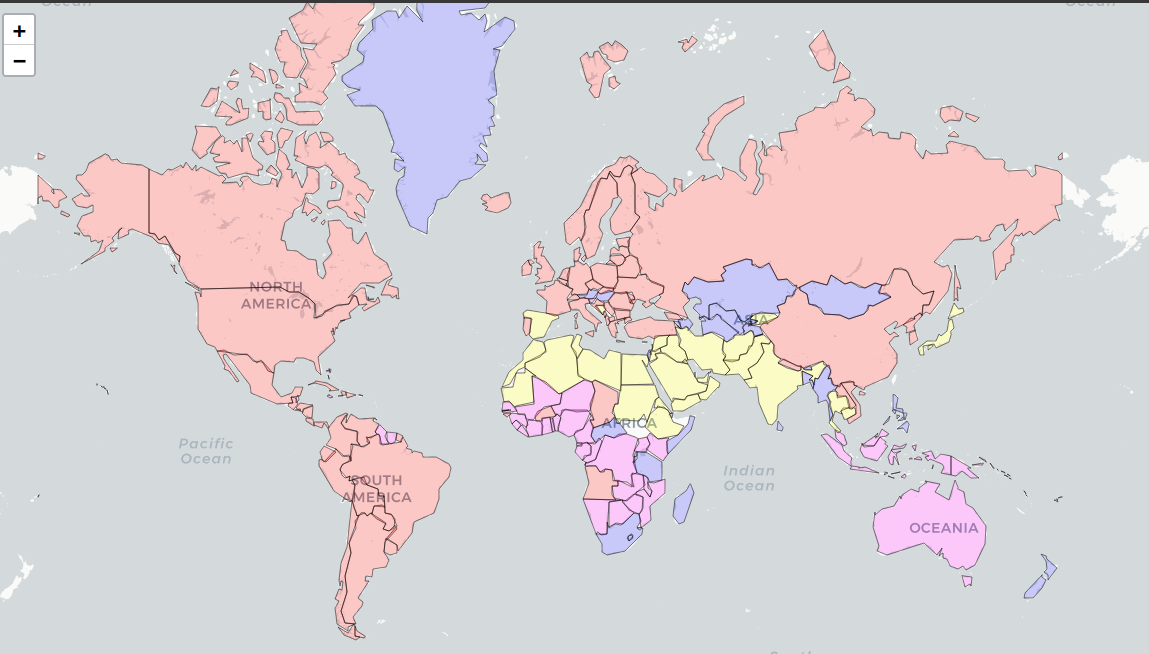

## paraphrase-multilingual-MiniLM-L12-v2
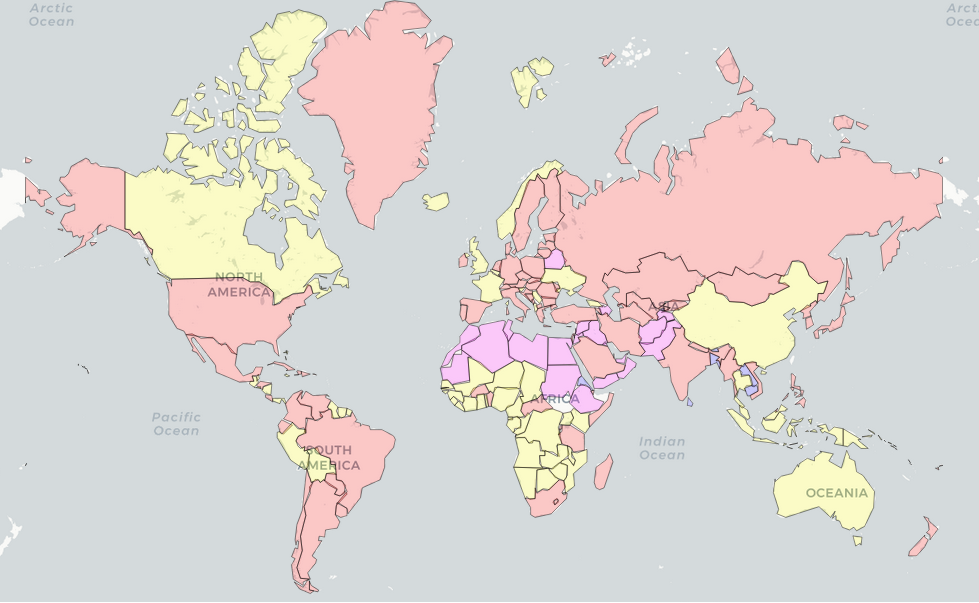

## distiluse-base-multilingual-cased-v1

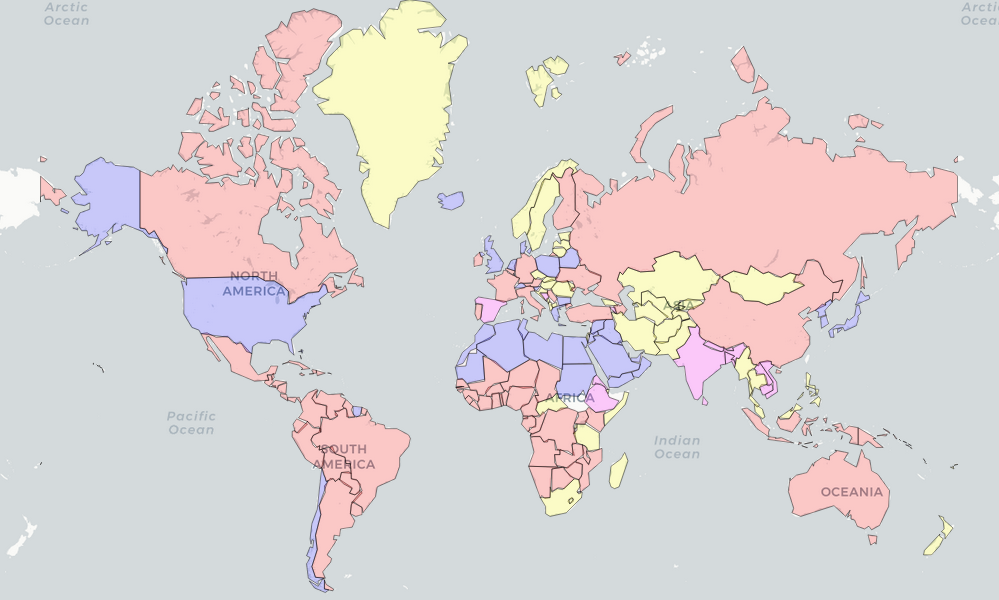

## xlm roberta
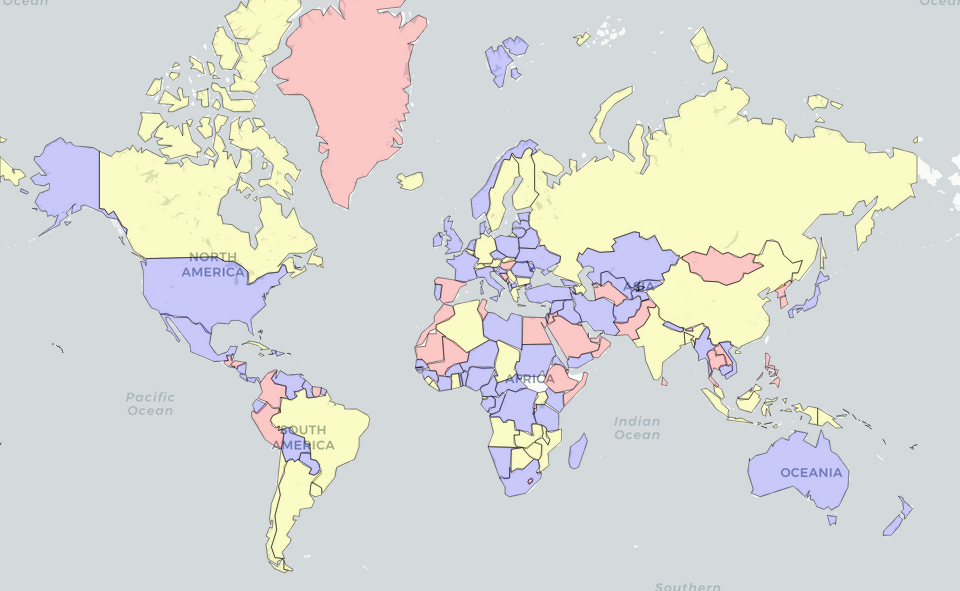

## mbert
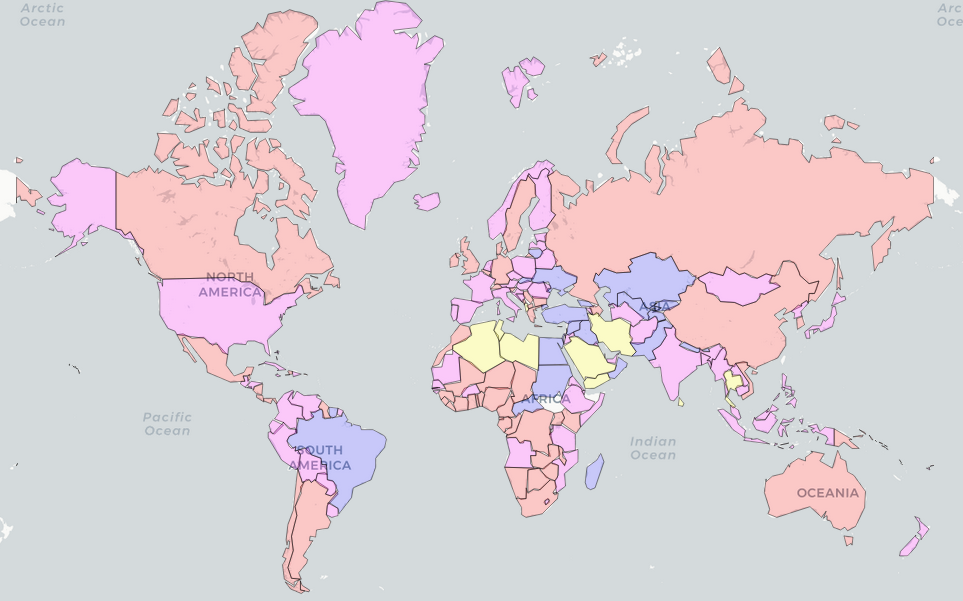

# Garage

In [3]:
# listen to audio
from IPython.display import Audio
from IPython.display import display
wn = Audio('in.mp3')
display(wn)